## Genearte, Plug-in, and Validate Carbon Yield Cuvres in the Whole TSA 24 Model

### Set Up Modelling Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install libcbm Module from GitHub and Import it
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

### Create and Run `ws3 Model`

In [3]:
# Import Modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import time
import numpy as np
import libcbm

In [4]:
# Set Basic Parameters
base_year = 2020
horizon = 20
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [5]:
# Creat Forest Model Instance for Timber Supply Area 24
fm = ws3.forest.ForestModel(model_name='tsa24',
                            model_path='data/woodstock_model_files_tsa24',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [6]:
# Import Modules
from util import compile_scenario, plot_scenario

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

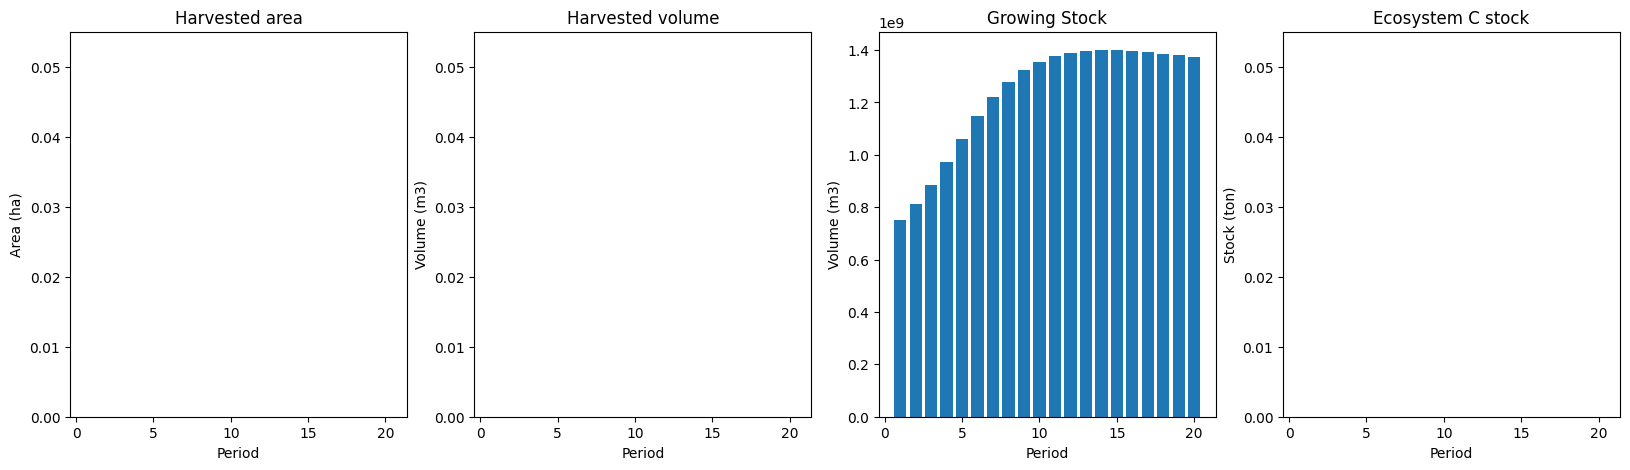

In [7]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario(fm)
plot_scenario(df)

### Hard-link `ForestModel` to `libcbm`

Prepare libcbm input files

In [8]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [9]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

In [10]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

In [11]:
# Run CBM and Generate CBM 0utputs
from util import run_cbm
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [12]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                    
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [13]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [14]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
total_emission = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['total_emission', 'gross_growth', 'net_emission']

### Generate and Add Carbon Yield Curves

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [15]:
sit_events = sit_tables['sit_events']

In [16]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [17]:
sit_inventory = sit_tables['sit_inventory']

In [18]:
sit_inventory

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,0,2401000,100,2401000,softwood,FALSE,5,345.7,0,0,fire,fire
1,tsa24,0,2401000,100,2401000,softwood,FALSE,15,825.8,0,0,fire,fire
2,tsa24,0,2401000,100,2401000,softwood,FALSE,25,1611.1,0,0,fire,fire
3,tsa24,0,2401000,100,2401000,softwood,FALSE,35,1508.5,0,0,fire,fire
4,tsa24,0,2401000,100,2401000,softwood,FALSE,45,264.0,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,tsa24,1,2403007,100,2423007,softwood,FALSE,25,7712.3,0,0,fire,harvest
766,tsa24,1,2403007,100,2423007,softwood,FALSE,35,15703.9,0,0,fire,harvest
767,tsa24,1,2403007,100,2423007,softwood,FALSE,45,11587.8,0,0,fire,harvest
768,tsa24,1,2403007,100,2423007,softwood,FALSE,55,6871.6,0,0,fire,harvest


In [19]:
# Set Age and Area to 0 and 1.0
df = sit_inventory
df['age'] = df['age'].apply(lambda x: 1)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)

In [20]:
df

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,0,2401000,100,2401000,softwood,FALSE,1,1.0,0,0,fire,fire
1,tsa24,0,2401001,304,2401001,softwood,FALSE,1,1.0,0,0,fire,fire
2,tsa24,0,2401003,304,2401003,softwood,FALSE,1,1.0,0,0,fire,fire
3,tsa24,0,2401004,104,2401004,softwood,FALSE,1,1.0,0,0,fire,fire
4,tsa24,0,2401005,1201,2401005,hardwood,FALSE,1,1.0,0,0,fire,fire
5,tsa24,0,2401006,1201,2401006,hardwood,FALSE,1,1.0,0,0,fire,fire
6,tsa24,0,2402001,304,2402001,softwood,FALSE,1,1.0,0,0,fire,fire
7,tsa24,0,2402005,1201,2402005,hardwood,FALSE,1,1.0,0,0,fire,fire
8,tsa24,0,2402006,1201,2402006,hardwood,FALSE,1,1.0,0,0,fire,fire
9,tsa24,0,2403005,1201,2403005,hardwood,FALSE,1,1.0,0,0,fire,fire


In [21]:
# Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [ ]:
# Run libcbm and Generate libcbm outputs
cbm_output_curves = run_cbm(sit_config, sit_tables, n_steps=700)

Set the timestep as 700 years to generate a 700-year-long carbon yield curve to simulate the old forest stand's (e.g., 500 years) carbon dynamics in the next 200-year simulation horizon.

In [ ]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [ ]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)

In [ ]:
# Generate Carbon Pool and Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [ ]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [ ]:
c_curves_p

In [ ]:
# Save curves to a pickle file
c_curves_p.to_pickle("curves/c_curves_p.pkl")

In [ ]:
c_curves_f['total_emission'] = c_curves_f[total_emission].sum(axis=1)
c_curves_f['gross_growth'] = c_curves_f[gross_growth].sum(axis=1)
c_curves_f['net_emission'] = c_curves_f['total_emission'] - c_curves_f['gross_growth']

In [ ]:
# Update the values of timestep 0 to be equal to timestep 1
c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 0] = c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 1].values

In [ ]:
c_curves_f

In [ ]:
# Save curves to pickle file
c_curves_f.to_pickle("curves/c_curves_f.pkl")

Plug-in carbon yield curves

In [ ]:
from util import plugin_c_curves
plugin_c_curves(fm, c_curves_p, c_curves_f, sum_pools, sum_fluxes)

#### No-harvesting

Under this scenario, no harvesting activity is applied on the forest landscape.

In [ ]:
# Compare ws3 and libcbm carbon modelling outputs for different carbon stock pools in the same graph
from util import compare_ws3_libcbm
df_cbm, df_ws3 = compare_ws3_libcbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, plots='whole', filename='no_harvest_carbon_stock_whole_st.pdf')

In [ ]:
# Compare ws3 and libcbm carbon modelling outputs for different carbon pools in individual graphs
df_cbm, df_ws3 = compare_ws3_libcbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, plots='individual', filename='no_harvest_carbon_dynamics_individual_st.pdf')

In [ ]:
# Define the function to calculate percentage differences between carbon modelling outputs from ws3 and libcbm for each carbon pool (libcbm results are set as benchmark values for reference)
def pct_diff(df_ws3, df_cbm, timestep='period', metrics=None):
    
    if metrics is None:
        metrics = ['biomass_stock', 'dom_stock', 'eco_stock', 'net_emission']
    
    a = df_ws3.set_index(timestep)[metrics]
    b = df_cbm .set_index(timestep)[metrics]
    
    diff = (a - b).div(b).mul(100)
    
    return diff.reset_index()

In [ ]:
df_diff = pct_diff(df_ws3, df_cbm)
df_diff

#### Maximize Even-flow Harvesting

Under this scenario, intensive harvesting activities are applied on the forest landscape to maximize the even-flow harvest volume.

In [ ]:
#Install Module
%pip install gurobipy

In [ ]:
#Import Module
import gurobipy as grb
from util import cmp_c_z, cmp_c_caa, cmp_c_cflw, cmp_c_ci, gen_scenario, run_scenario

In [ ]:
#Add a Null Action
fm.add_null_action()

In [ ]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode = 'harvest'
fm.actions[harvest_acode].is_harvest = True

In [42]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

running base scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-24
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 850 rows, 45499 columns and 926885 nonzeros
Model fingerprint: 0x85255d2d
Coefficient statistics:
  Matrix range     [2e-10, 5e+07]
  Objective range  [9e+02, 9e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.24s
Presolved: 516 rows, 44729 columns, 896031 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.482e+04
 Factor NZ  : 4.215e+04 (roughly 20 MB of memory)
 Factor O

(    period            oha           ohv           ogs           ocp  ocf
 0        1  388288.019629  7.844764e+07  6.571134e+08  1.215997e+09  0.0
 1        2  368873.618647  8.237002e+07  6.236612e+08  1.192762e+09  0.0
 2        3  368873.618647  8.237002e+07  5.999846e+08  1.178779e+09  0.0
 3        4  368873.618647  8.064385e+07  5.871034e+08  1.166438e+09  0.0
 4        5  368873.618647  7.452526e+07  5.850273e+08  1.155634e+09  0.0
 5        6  368873.618647  7.553333e+07  5.804989e+08  1.151088e+09  0.0
 6        7  368873.618647  8.237002e+07  5.635106e+08  1.145931e+09  0.0
 7        8  368873.618647  8.043997e+07  5.462524e+08  1.139948e+09  0.0
 8        9  368873.618647  7.452526e+07  5.347003e+08  1.132213e+09  0.0
 9       10  368873.618647  7.452526e+07  5.248458e+08  1.130241e+09  0.0
 10      11  368873.618647  7.452526e+07  5.174522e+08  1.133325e+09  0.0
 11      12  368873.618647  7.452526e+07  5.130326e+08  1.136143e+09  0.0
 12      13  407702.420610  7.452526e+

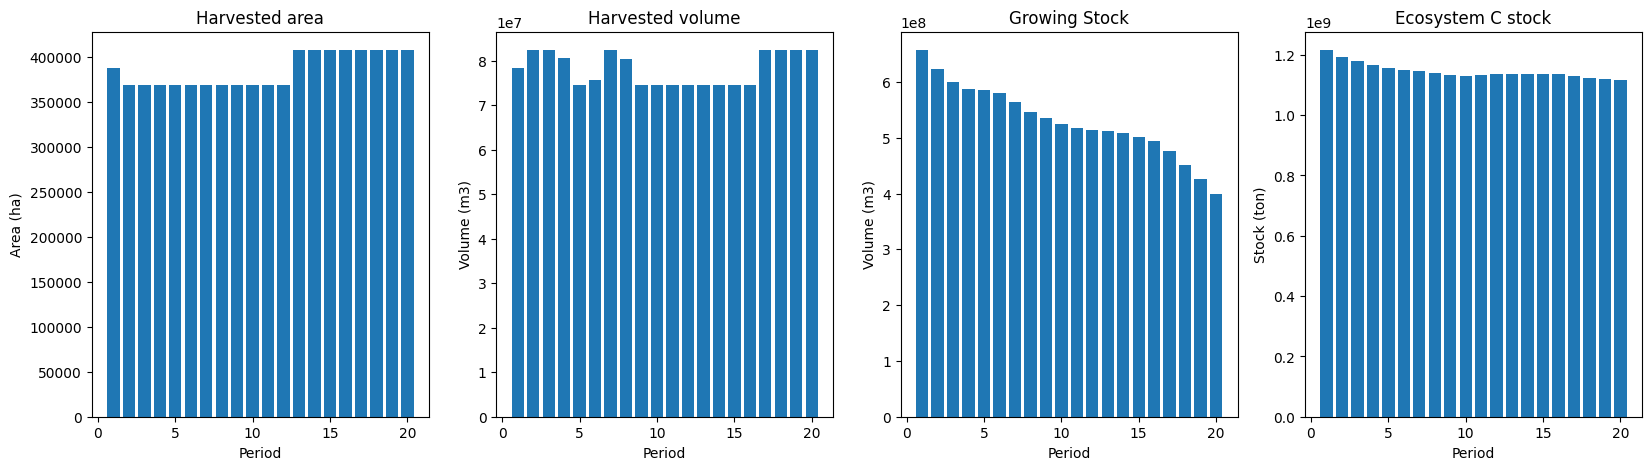

In [43]:
# Run the base scenario to maximize the even-flow harvest volume from the modelling area
run_scenario(fm,'base')

In [44]:
#Import Modulaa
from util import compile_events

In [45]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [46]:
#Generate New Sit_events file
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [47]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [48]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa24,1,2401002,204,2401002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,4035.567658,harvest,1
1,tsa24,1,2401002,204,2401002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,17680.100000,harvest,1
2,tsa24,1,2401002,204,2401002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,12550.400000,harvest,1
3,tsa24,1,2401002,204,2401002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,9093.800000,harvest,1
4,tsa24,1,2401002,204,2401002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,4673.400000,harvest,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,tsa24,1,2403000,100,2423000,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,175925.640001,harvest,191
569,tsa24,1,2403002,204,2423002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,61919.136029,harvest,191
570,tsa24,1,2403003,304,2423003,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,8481.100000,harvest,191
571,tsa24,1,2403003,304,2423003,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,6263.200000,harvest,191


In [49]:
# Run CBM and Generate CBM Ouputs
cbm_output_harvest = run_cbm(sit_config, sit_tables, n_steps)

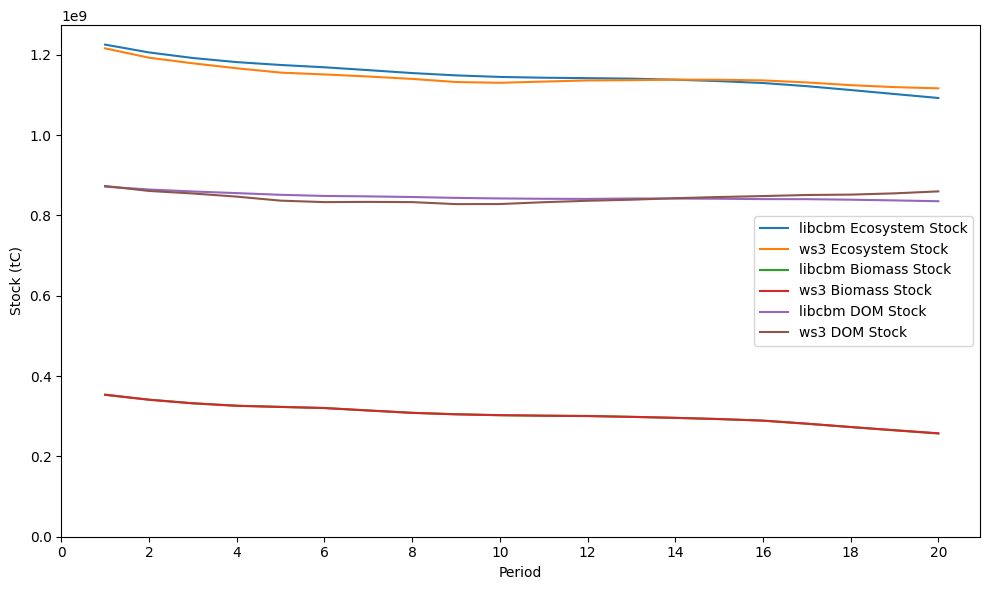

In [50]:
# Compare ws3 and libcbm carbon modelling outputs for different carbon stock pools in the same graph
df_cbm, df_ws3 = compare_ws3_libcbm(fm, cbm_output_harvest, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, plots='whole', filename='maximize_harvest_carbon_stock_whole_st.pdf')

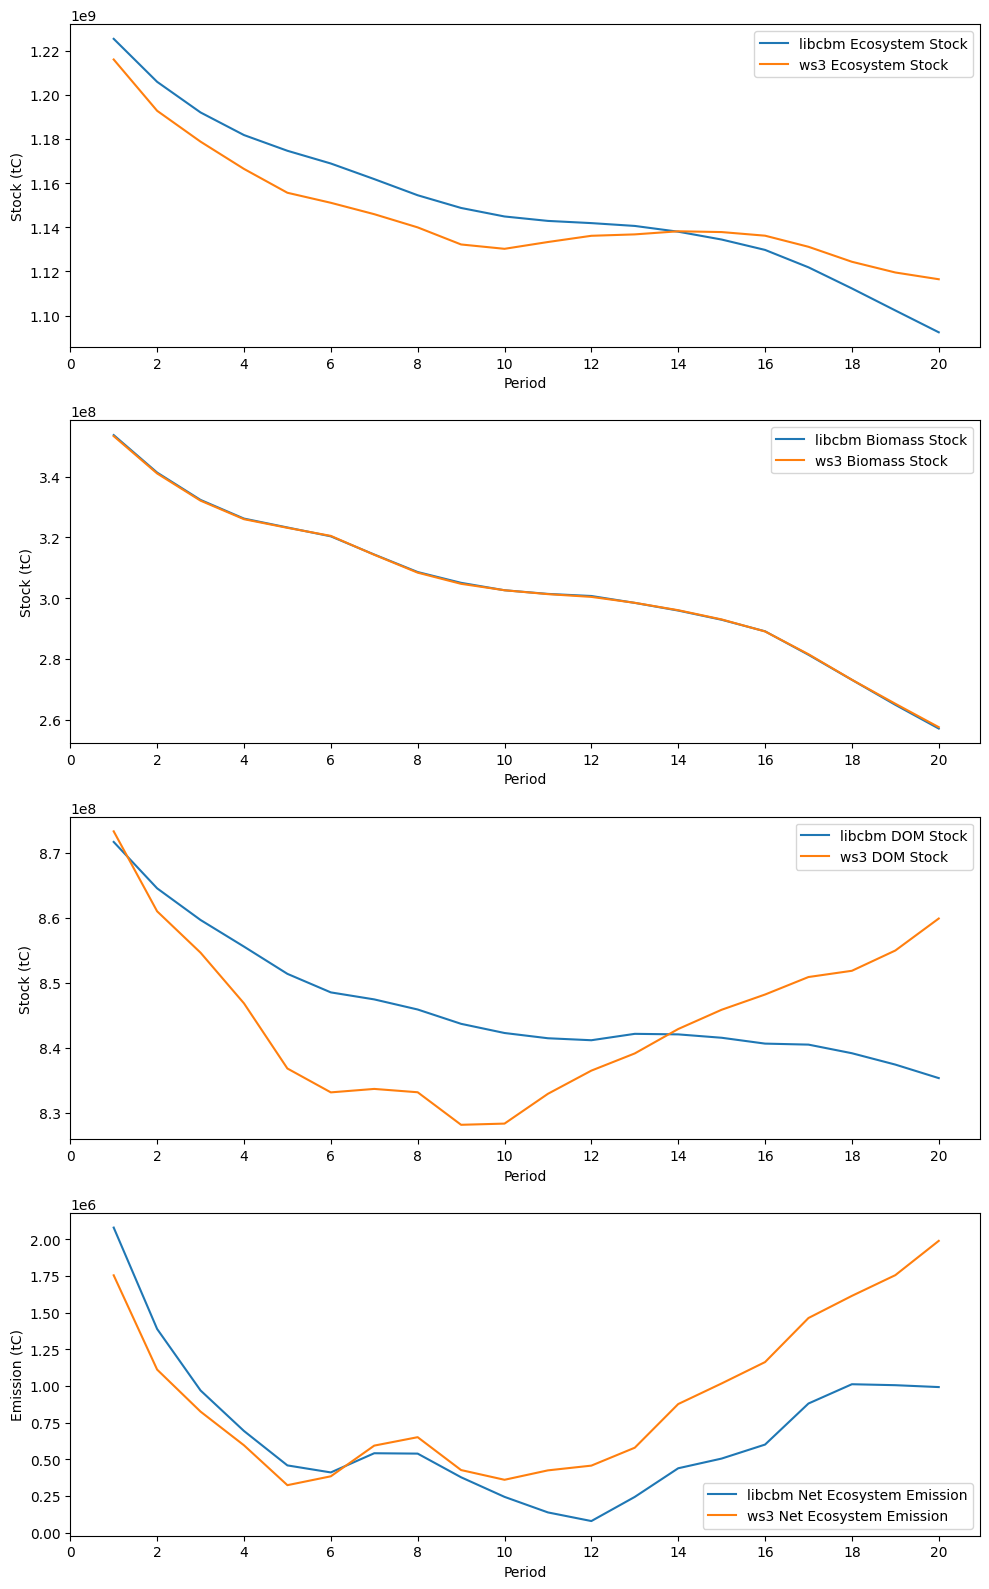

In [51]:
# Compare ws3 and libcbm carbon modelling outputs for different carbon pools in individual graphs
df_cbm, df_ws3 = compare_ws3_libcbm(fm, cbm_output_harvest, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, plots='individual', filename='maximize_harvest_carbon_dynamics_individual_st.pdf')

In [52]:
df_ws3

,period,biomass_stock,dom_stock,eco_stock,net_emission
0,1,3.533395e+08,8.732978e+08,1.215997e+09,1.753558e+06
1,2,3.410467e+08,8.610001e+08,1.192762e+09,1.110999e+06
2,3,3.320932e+08,8.546385e+08,1.178779e+09,8.246492e+05
3,4,3.259926e+08,8.468505e+08,1.166438e+09,5.951833e+05
4,5,3.231540e+08,8.368299e+08,1.155634e+09,3.233103e+05
5,6,3.205002e+08,8.331592e+08,1.151088e+09,3.837348e+05
6,7,3.142759e+08,8.336898e+08,1.145931e+09,5.929005e+05
7,8,3.083944e+08,8.331774e+08,1.139948e+09,6.503332e+05
8,9,3.047169e+08,8.281726e+08,1.132213e+09,4.262650e+05
9,10,3.026084e+08,8.283566e+08,1.130241e+09,3.600393e+05


In [53]:
df_cbm

,period,biomass_stock,dom_stock,eco_stock,total_emission,gross_growth,net_emission
0,1,3.536816e+08,8.716688e+08,1.225350e+09,1.956530e+07,1.748651e+07,2.078793e+06
1,2,3.413476e+08,8.645343e+08,1.205882e+09,1.888501e+07,1.749715e+07,1.387864e+06
2,3,3.323432e+08,8.596670e+08,1.192010e+09,1.848414e+07,1.751529e+07,9.688528e+05
3,4,3.261975e+08,8.555737e+08,1.181771e+09,1.816414e+07,1.747149e+07,6.926409e+05
4,5,3.232685e+08,8.513857e+08,1.174654e+09,1.785413e+07,1.739608e+07,4.580480e+05
5,6,3.203503e+08,8.485329e+08,1.168883e+09,1.765809e+07,1.724791e+07,4.101818e+05
6,7,3.143638e+08,8.474551e+08,1.161819e+09,1.758719e+07,1.704626e+07,5.409280e+05
7,8,3.086036e+08,8.459021e+08,1.154506e+09,1.747149e+07,1.693311e+07,5.383713e+05
8,9,3.050477e+08,8.436991e+08,1.148747e+09,1.731990e+07,1.694281e+07,3.770886e+05
9,10,3.026022e+08,8.422889e+08,1.144891e+09,1.724034e+07,1.699674e+07,2.435961e+05


In [54]:
df_diff = pct_diff(df_ws3, df_cbm)
df_diff

,period,biomass_stock,dom_stock,eco_stock,net_emission
0,1,-0.096718,0.186878,-0.763311,-15.645411
1,2,-0.088162,-0.408800,-1.088035,-19.948983
2,3,-0.075225,-0.584925,-1.110009,-14.883949
3,4,-0.062803,-1.019581,-1.297454,-14.070437
4,5,-0.035444,-1.709655,-1.619257,-29.415613
5,6,0.046814,-1.811796,-1.522375,-6.447624
6,7,-0.027942,-1.624315,-1.367462,9.608010
7,8,-0.067771,-1.504282,-1.260961,20.796412
8,9,-0.108456,-1.840282,-1.439293,13.041053
9,10,0.002034,-1.654096,-1.279588,47.801797
